# Creating a motif finder


In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt

# only allow 100 rows to display pandas
pd.set_option('display.max_rows', 100)

In [35]:
syn_table = pd.read_csv('/Users/rweberla/Downloads/connections.csv')
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [36]:
# Find all unique cell ids in both the pre and post columns
cellids =  np.unique(syn_table[["pre_root_id", "post_root_id"]])
print(len(cellids))

134181


In [37]:
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [47]:
# Find 720575940628360506 and oviEN in both pre_root_id or post_root_id columns
syn_table_limit_test = syn_table[["pre_root_id", "post_root_id"]]
syn_table_limit_test 

,pre_root_id,post_root_id
0,720575940629970489,720575940631267655
1,720575940605876866,720575940606514878
2,720575940627737365,720575940628914436
3,720575940633587552,720575940626452879
4,720575940616871878,720575940621203973
...,...,...
3869873,720575940621773517,720575940611139733
3869874,720575940622734576,720575940609171395
3869875,720575940638466367,720575940627036426
3869876,720575940629789660,720575940631553603


## Found this function called succesors in networkx!
This allows you to create a directed graph and find all triads in this reference:
- Snijders, T. (2012). “Transitivity and triads.” University of Oxford. https://web.archive.org/web/20170830032057/http://www.stats.ox.ac.uk/~snijders/Trans_Triads_ha.pdf

Our motif is the "120U". We will probably need to use the HPC to do the whole connectome. 

This method was developed with help from co-pilot. The testing was done with df_test

In [39]:
# Isolated test for exact motif we want
e_test= [(720575940629970489,720575940629970489), (720575940629970489,720575940605876866), (720575940629970489,720575940629970489), (720575940629970489,720575940605876866)]
df_test = pd.DataFrame(columns=["s", "t"], data = e_test)
v_test = np.unique(df_test[["s", "t"]])
df_test

,s,t
0,720575940629970489,720575940629970489
1,720575940629970489,720575940605876866
2,720575940629970489,720575940629970489
3,720575940629970489,720575940605876866


In [48]:
G = nx.DiGraph()
# Add the edges to the graph from dataframe
G.add_edges_from(syn_table_limit_test.values)

# Plot the graph
#nx.draw(G, with_labels=True)

In [46]:
len(G.nodes())

129351

In [50]:
num_120U_triads = 0
tri_by_type = defaultdict(list)
unique_triads = set()

print("Starting to count triads")
for i, A in enumerate(G.nodes()):
    # Find all successors of A
    for B in G.successors(A):
        for C in G.successors(A):
            if B != C and G.has_edge(C, A) and G.has_edge(C, B):
                # Sort the nodes to ensure consistency
                triad = tuple(sorted([A, B, C]))
                if triad not in unique_triads:
                    unique_triads.add(triad)
                    # Identify the reciprocal nodes and the third node
                    if G.has_edge(A, B) and G.has_edge(B, A):
                        reciprocal_nodes = (A, B)
                        third_node = C
                    elif G.has_edge(A, C) and G.has_edge(C, A):
                        reciprocal_nodes = (A, C)
                        third_node = B
                    elif G.has_edge(B, C) and G.has_edge(C, B):
                        reciprocal_nodes = (B, C)
                        third_node = A
                    tri_by_type["120U"].append([reciprocal_nodes,third_node])
                    num_120U_triads += 1

    if (i+1)%10000 == 0:
        print(f"Processed {i} nodes")
        print(f"Found {num_120U_triads} 120U triads")

Starting to count triads
Processed 9999 nodes
Found 839882 120U triads
Processed 19999 nodes
Found 1235851 120U triads
Processed 29999 nodes
Found 1368714 120U triads
Processed 39999 nodes
Found 1429556 120U triads
Processed 49999 nodes
Found 1463140 120U triads
Processed 59999 nodes
Found 1481539 120U triads
Processed 69999 nodes
Found 1492751 120U triads
Processed 79999 nodes
Found 1499295 120U triads
Processed 89999 nodes
Found 1503029 120U triads
Processed 99999 nodes
Found 1505074 120U triads
Processed 109999 nodes
Found 1505888 120U triads
Processed 119999 nodes
Found 1506135 120U triads
Processed 129999 nodes
Found 1506182 120U triads


In [60]:
# Save tri_by_type to a txt file, /Users/rweberla/Downloads/wholeNet_120U_triads.txt
with open('/Users/rweberla/Downloads/wholeNet_120U_triads.txt', 'w') as f:
    for item in tri_by_type["120U"]:
        f.write("%s\n" % item)


In [43]:
num_120U_triads

0

# Testing for descending type finding
1. Import run data
2. import descending data
3. Compare!

In [62]:
# Import txt file, there is also a parenthesis issue (at the beginning and end of each line, need to get rid of them)
df_found = pd.read_csv('/Users/rweberla/Downloads/wholeNet_120U_triads.txt', sep=",", header=None, names=["reciprocal1", "reciprocal2", "nid"])
# Strip the parenthesis from the column values
df_found["reciprocal1"] = df_found["reciprocal1"].str.strip("[(")
df_found["reciprocal2"] = df_found["reciprocal2"].str.strip(")")
df_found["nid"] = df_found["nid"].str.strip("])")
df_found

,reciprocal1,reciprocal2,nid
0,720575940629970489,720575940627604977,720575940631267655
1,720575940629970489,720575940628049963,720575940620005542
2,720575940629970489,720575940627604977,720575940620005542
3,720575940629970489,720575940627604977,720575940626081319
4,720575940629970489,720575940615028143,720575940626081319
...,...,...,...
1506177,720575940632454456,720575940644534820,720575940614817064
1506178,720575940630682684,720575940621878125,720575940624821228
1506179,720575940625674388,720575940621938017,720575940608967004
1506180,720575940625674388,720575940621938017,720575940639258301


In [63]:
# Import descending data
df_desc = pd.read_csv('/Users/rweberla/Downloads/classification.csv')
df_desc

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN
...,...,...,...,...,...,...,...,...,...,...
139250,720575940632239661,afferent,sensory,olfactory,NaN,ORN_VM6l,ORN_VC5,NaN,right,AN
139251,720575940624423312,intrinsic,optic,NaN,NaN,TmY5a,NaN,NaN,right,NaN
139252,720575940625090916,intrinsic,optic,NaN,NaN,NaN,NaN,NaN,left,NaN
139253,720575940631596103,intrinsic,optic,NaN,NaN,T2a,NaN,NaN,left,NaN


In [64]:
# I want to change the data type of the nid column to int (83823.0 to 83823)
df_desc = df_desc[["root_id", "super_class"]].dropna()
df_desc

,root_id,super_class
0,720575940640144768,optic
1,720575940630759755,central
2,720575940637932009,central
3,720575940606131116,optic
4,720575940633723091,optic
...,...,...
139250,720575940632239661,sensory
139251,720575940624423312,optic
139252,720575940625090916,optic
139253,720575940631596103,optic


In [65]:
type(df_desc['root_id'][0])

numpy.int64

In [68]:
# Change the data type of the nid column to int
df_found['nid'] = df_found['nid'].astype(int)

# Combine nid from df_desc onto df_found, if there isn't a match then put "other"
df_found_desc = df_found.merge(df_desc, left_on='nid', right_on='root_id', how='left')
df_found_desc

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940629970489,720575940627604977,720575940631267655,720575940631267655,central
1,720575940629970489,720575940628049963,720575940620005542,720575940620005542,central
2,720575940629970489,720575940627604977,720575940620005542,720575940620005542,central
3,720575940629970489,720575940627604977,720575940626081319,720575940626081319,central
4,720575940629970489,720575940615028143,720575940626081319,720575940626081319,central
...,...,...,...,...,...
1506177,720575940632454456,720575940644534820,720575940614817064,720575940614817064,optic
1506178,720575940630682684,720575940621878125,720575940624821228,720575940624821228,optic
1506179,720575940625674388,720575940621938017,720575940608967004,720575940608967004,optic
1506180,720575940625674388,720575940621938017,720575940639258301,720575940639258301,optic


In [69]:
# Change root_id to see all numbers, int64
df_found_desc['root_id'] = df_found_desc['root_id'].astype('Int64')

In [70]:
df_found_desc

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940629970489,720575940627604977,720575940631267655,720575940631267655,central
1,720575940629970489,720575940628049963,720575940620005542,720575940620005542,central
2,720575940629970489,720575940627604977,720575940620005542,720575940620005542,central
3,720575940629970489,720575940627604977,720575940626081319,720575940626081319,central
4,720575940629970489,720575940615028143,720575940626081319,720575940626081319,central
...,...,...,...,...,...
1506177,720575940632454456,720575940644534820,720575940614817064,720575940614817064,optic
1506178,720575940630682684,720575940621878125,720575940624821228,720575940624821228,optic
1506179,720575940625674388,720575940621938017,720575940608967004,720575940608967004,optic
1506180,720575940625674388,720575940621938017,720575940639258301,720575940639258301,optic


Text(0.5, 1.0, 'Number of 120U Triads by Super Class')

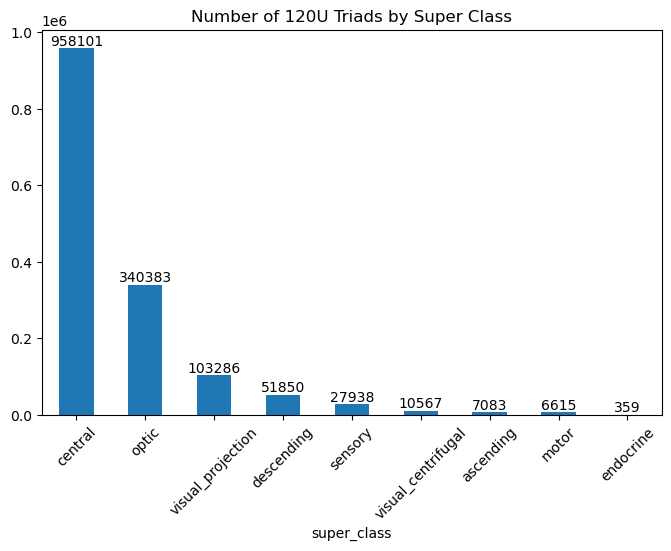

In [71]:
# Analyze the data, make a bar plot for each super_class and count up the rows 
fig, ax = plt.subplots(figsize=(8,5))
df_found_desc["super_class"].value_counts().plot(kind='bar')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

# Add in labels for each bar
for i, v in enumerate(df_found_desc["super_class"].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Add in a title
plt.title("Number of 120U Triads by Super Class")

In [72]:
# 
df_found_desc_unique = df_found_desc.drop_duplicates(subset=["nid"])
df_found_desc_unique

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940629970489,720575940627604977,720575940631267655,720575940631267655,central
1,720575940629970489,720575940628049963,720575940620005542,720575940620005542,central
3,720575940629970489,720575940627604977,720575940626081319,720575940626081319,central
5,720575940629970489,720575940627604977,720575940624508563,720575940624508563,central
7,720575940629970489,720575940627604977,720575940652336801,720575940652336801,central
...,...,...,...,...,...
1506165,720575940660151425,720575940625937338,720575940631156781,720575940631156781,optic
1506170,720575940628024207,720575940605092700,720575940612818069,720575940612818069,optic
1506172,720575940631735121,720575940610979590,720575940640745587,720575940640745587,optic
1506176,720575940645002276,720575940632381009,720575940639633205,720575940639633205,optic


Text(0, 0.5, 'Triad Count')

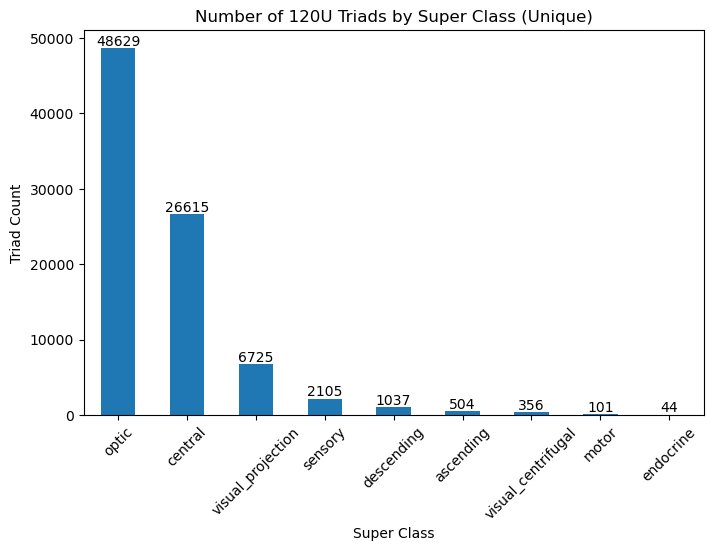

In [73]:
# Filter dataframe so there are only unique nid values
fig, ax = plt.subplots(figsize=(8,5))
df_found_desc_unique["super_class"].value_counts().plot(kind='bar')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

# Add in labels for each bar
for i, v in enumerate(df_found_desc_unique["super_class"].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Add in a title
plt.title("Number of 120U Triads by Super Class (Unique)")
plt.xlabel("Super Class")
plt.ylabel("Triad Count")

In [74]:
# Print out counts for each super_class
df_found_desc_unique["super_class"].value_counts()


super_class
optic                 48629
central               26615
visual_projection      6725
sensory                2105
descending             1037
ascending               504
visual_centrifugal      356
motor                   101
endocrine                44
Name: count, dtype: int64

In [75]:
# Create a portionality column to see the percentage of each super_class, 
# This means counting the number of rows for each super_class and dividing by the total number of rows (normalize)
# The map function here maps each super_class to the proportionality value found in the value_counts
df_found_desc_unique["proportionality"] = df_found_desc_unique["super_class"].map(df_found_desc_unique["super_class"].value_counts(normalize=True))
df_found_desc_unique

/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_61779/903167673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_found_desc_unique["proportionality"] = df_found_desc_unique["super_class"].map(df_found_desc_unique["super_class"].value_counts(normalize=True))


,reciprocal1,reciprocal2,nid,root_id,super_class,proportionality
0,720575940629970489,720575940627604977,720575940631267655,720575940631267655,central,0.309060
1,720575940629970489,720575940628049963,720575940620005542,720575940620005542,central,0.309060
3,720575940629970489,720575940627604977,720575940626081319,720575940626081319,central,0.309060
5,720575940629970489,720575940627604977,720575940624508563,720575940624508563,central,0.309060
7,720575940629970489,720575940627604977,720575940652336801,720575940652336801,central,0.309060
...,...,...,...,...,...,...
1506165,720575940660151425,720575940625937338,720575940631156781,720575940631156781,optic,0.564692
1506170,720575940628024207,720575940605092700,720575940612818069,720575940612818069,optic,0.564692
1506172,720575940631735121,720575940610979590,720575940640745587,720575940640745587,optic,0.564692
1506176,720575940645002276,720575940632381009,720575940639633205,720575940639633205,optic,0.564692


In [76]:
# Isolate each super class and their portionality
df_pro_class = df_found_desc_unique[['super_class', 'proportionality']].drop_duplicates().dropna()
df_pro_class = df_pro_class.sort_values(by="proportionality", ascending=False).reset_index(drop=True)
df_pro_class

,super_class,proportionality
0,optic,0.564692
1,central,0.309060
2,visual_projection,0.078092
3,sensory,0.024444
4,descending,0.012042
5,ascending,0.005853
6,visual_centrifugal,0.004134
7,motor,0.001173
8,endocrine,0.000511


Text(0.5, 1.0, 'Proportionality of Super Classes Occurance')

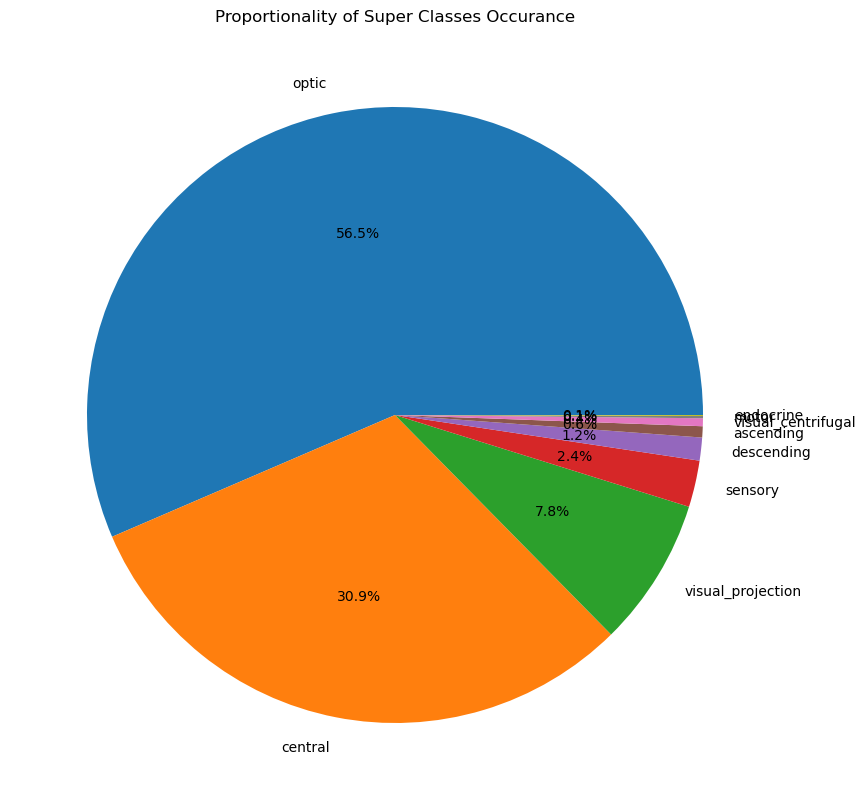

In [77]:
# Create a pie plot for the proportionality column for each super class
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(df_pro_class["proportionality"], labels=df_pro_class["super_class"], autopct='%1.1f%%')

# Add a title to the plot
plt.title("Proportionality of Super Classes Occurance")

# Print out percentage of each super class



In [78]:
# Isolate 
descending_only = (df_found_desc_unique[df_found_desc_unique['super_class']=='descending']).reset_index(drop=True)
descending_only_small = descending_only.head(2)


In [79]:
descending_only_small

,reciprocal1,reciprocal2,nid,root_id,super_class,proportionality
0,720575940629970489,720575940631131436,720575940610505006,720575940610505006,descending,0.012042
1,720575940629970489,720575940631131436,720575940611644529,720575940611644529,descending,0.012042


This next part will be 
1. a for loop that iterates through the triads of df_found 
2. syn_table_f is filtered for just the edges in that triad (all possible combos)
3. those rows (plus all columns) will be attached to df_triad_final
4. the triad index will be the triad index from the df_found, for example for each connection that makes up the triad in the first row of df_found (index=0), their indexes will be 0 in the df_traid_final dataframe, so around 4 of them should be 0 since they are all 120U

In [80]:
# Create a dataframe wtih multiIndex and populate traid column to 286724 rows all with 0
# a for loop that iterates through the rows of df_found
def triad_info(df):
    df_new = pd.DataFrame(columns=["pre_root_id", "post_root_id", "neuropil", "syn_count", 'nt_type', 'triad'])
    for index, row in df.iterrows():
        # For large set runs:
        if (index+1)%10000 == 0:
            print("10000 done!")
        
        # Find the pre_root_id and post_root_id of the edge1, edge2, and edge3
        id_1 = int(row["reciprocal1"])
        id_2 = int(row["reciprocal2"])
        id_3 = int(row["nid"])
        
        # Find connections in the syn_table_f that match the combinations of id_1, id_2, and id_3
        # use combinations to find all possible combinations of the 3 ids
        for comb in permutations([id_1, id_2, id_3], 2):

            # Find the rows that match the combinations
            rows = syn_table[(syn_table["pre_root_id"] == comb[0]) & (syn_table["post_root_id"] == comb[1])]
            
            # If there are rows that match the combinations
            if not rows.empty:
                # Add the triad value to the rows
                rows["triad"] = index+1
                # Add the rows to the df_new dataframe
                df_new = pd.concat([df_new, rows]).reset_index(drop=True)

    return df_new

In [81]:
df_small_desc = triad_info(descending_only_small)
df_small_desc

/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_61779/3914838819.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["triad"] = index+1
/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_61779/3914838819.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["triad"] = index+1
/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_61779/3914838819.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940629970489,720575940631131436,PVLP_R,1,GABA,1
1,720575940629970489,720575940631131436,AVLP_R,5,GABA,1
2,720575940629970489,720575940610505006,PLP_R,14,GABA,1
3,720575940629970489,720575940610505006,WED_R,3,GABA,1
4,720575940629970489,720575940610505006,AVLP_R,5,GABA,1
5,720575940629970489,720575940610505006,PVLP_R,2,GABA,1
6,720575940631131436,720575940629970489,PVLP_R,1,GABA,1
7,720575940631131436,720575940629970489,AVLP_R,4,GLUT,1
8,720575940631131436,720575940610505006,ICL_R,2,GLUT,1
9,720575940631131436,720575940610505006,PVLP_R,1,ACH,1


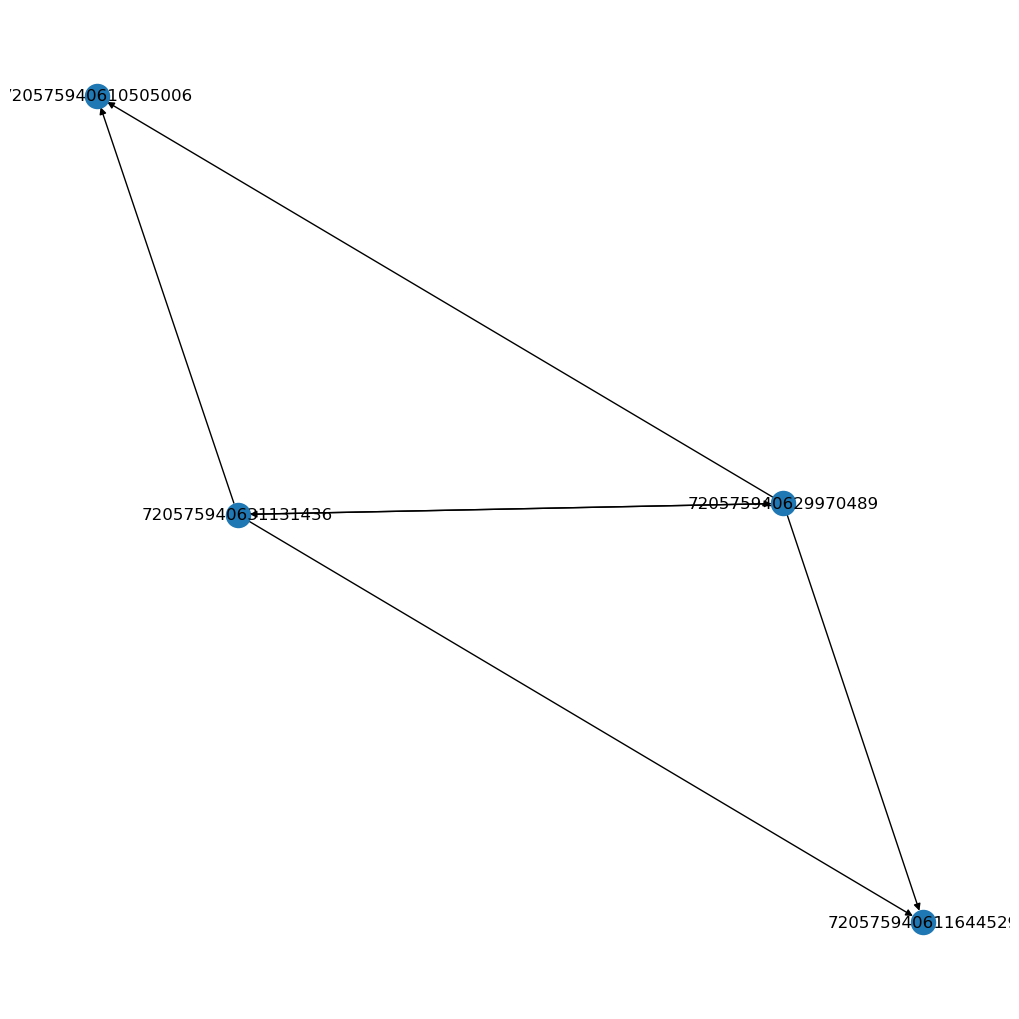

In [83]:
# Make a network graph of the descending super class
G = nx.DiGraph()
plt.figure(figsize=(10, 10))
# Add the edges to the graph from dataframe
G.add_edges_from(df_small_desc[["pre_root_id", "post_root_id"]].values)
# Plot the graph
nx.draw(G, with_labels=True)


### Running the info finder on the Whole dataframe

In [84]:
descending_only

,reciprocal1,reciprocal2,nid,root_id,super_class,proportionality
0,720575940629970489,720575940631131436,720575940610505006,720575940610505006,descending,0.012042
1,720575940629970489,720575940631131436,720575940611644529,720575940611644529,descending,0.012042
2,720575940605876866,720575940624296328,720575940631520312,720575940631520312,descending,0.012042
3,720575940619895125,720575940614113682,720575940644494752,720575940644494752,descending,0.012042
4,720575940619895125,720575940611379569,720575940628352850,720575940628352850,descending,0.012042
...,...,...,...,...,...,...
1032,720575940626574108,720575940622267260,720575940637870510,720575940637870510,descending,0.012042
1033,720575940617407030,720575940612843762,720575940626745987,720575940626745987,descending,0.012042
1034,720575940617407030,720575940612843762,720575940629956695,720575940629956695,descending,0.012042
1035,720575940629806974,720575940639634304,720575940621767306,720575940621767306,descending,0.012042


In [85]:
# Info finder on descending_only df
# Turn off warning for SettingWithCopyWarning
pd.options.mode.chained_assignment = None
df_descending_all_info = triad_info(descending_only)
df_descending_all_info

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940629970489,720575940631131436,PVLP_R,1,GABA,1
1,720575940629970489,720575940631131436,AVLP_R,5,GABA,1
2,720575940629970489,720575940610505006,PLP_R,14,GABA,1
3,720575940629970489,720575940610505006,WED_R,3,GABA,1
4,720575940629970489,720575940610505006,AVLP_R,5,GABA,1
...,...,...,...,...,...,...
12019,720575940639634304,720575940621767306,GNG,10,ACH,1036
12020,720575940629806974,720575940639634304,GNG,10,ACH,1037
12021,720575940629806974,720575940627500279,GNG,5,SER,1037
12022,720575940639634304,720575940629806974,GNG,67,ACH,1037


In [88]:
# I want to find the triad with the highest syn_count, this means for each triad value, find the max syn_count for the rows that have that triad value
df_descending_all_info = df_descending_all_info.dropna()

# Group by triad and sum the syn_count values
triad_max_finder = df_descending_all_info.groupby("triad")["syn_count"].sum().reset_index()
# sorts the values by syn_count in descending order
triad_max_finder = triad_max_finder.sort_values(by="syn_count", ascending=False).reset_index(drop=True)
triad_max_finder

,triad,syn_count
0,685,1046
1,688,1023
2,682,957
3,686,940
4,694,939
...,...,...
1032,194,24
1033,374,24
1034,986,23
1035,871,23


In [89]:
# Isolating triad 702
triad_702 = df_descending_all_info[df_descending_all_info["triad"] == 685]
triad_702

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
8406,720575940636552805,720575940633316307,GNG,455,ACH,685
8407,720575940636552805,720575940639634304,GNG,75,ACH,685
8408,720575940633316307,720575940636552805,GNG,451,ACH,685
8409,720575940633316307,720575940639634304,GNG,65,ACH,685


### Finding E/I Pairs....
I think this can be done by appending the info (nt or other) onto pre_root_id and then again on post_root_id, and then isolating the ones that are E/I!

In [90]:
df_found_desc

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940629970489,720575940627604977,720575940631267655,720575940631267655,central
1,720575940629970489,720575940628049963,720575940620005542,720575940620005542,central
2,720575940629970489,720575940627604977,720575940620005542,720575940620005542,central
3,720575940629970489,720575940627604977,720575940626081319,720575940626081319,central
4,720575940629970489,720575940615028143,720575940626081319,720575940626081319,central
...,...,...,...,...,...
1506177,720575940632454456,720575940644534820,720575940614817064,720575940614817064,optic
1506178,720575940630682684,720575940621878125,720575940624821228,720575940624821228,optic
1506179,720575940625674388,720575940621938017,720575940608967004,720575940608967004,optic
1506180,720575940625674388,720575940621938017,720575940639258301,720575940639258301,optic


In [92]:
# Import neurons info
df_n = pd.read_csv('/Users/rweberla/Downloads/neurons.csv')
df_neurons = df_n[["root_id", "nt_type"]]
df_neurons

,root_id,nt_type
0,720575940596125868,ACH
1,720575940597856265,ACH
2,720575940597944841,ACH
3,720575940598267657,GABA
4,720575940599333574,ACH
...,...,...
139250,720575940661335681,GABA
139251,720575940661336193,ACH
139252,720575940661337217,ACH
139253,720575940661338497,NaN


In [198]:
# Combine nid from df_neurons onto df_found_desc reciprocal1

df_filtered1 = df_found_desc.merge(df_neurons, left_on='reciprocal1', right_on='root_id', how="left",)
df_filtered2 = df_filtered1.merge(df_neurons, left_on='reciprocal2', right_on='root_id', how="left", suffixes=('_pre','_post'))
df_filtered2

,reciprocal1,reciprocal2,nid,root_id_x,super_class,root_id_y,nt_type_pre,root_id,nt_type_post
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central,720575940627737365,ACH,720575940628914436,NaN
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central,720575940627737365,ACH,720575940628914436,NaN
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central,720575940627737365,ACH,720575940628914436,NaN
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central,720575940627737365,ACH,720575940628914436,NaN
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central,720575940627737365,ACH,720575940628914436,NaN
...,...,...,...,...,...,...,...,...,...
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic,720575940628582888,NaN,720575940632232418,ACH
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic,720575940631261637,ACH,720575940619531072,GLUT
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic,720575940640153216,GABA,720575940626933706,ACH
99520,720575940628285973,720575940624948553,720575940624654570,720575940624654570,optic,720575940628285973,ACH,720575940624948553,GLUT


In [202]:
# Find reciprocal1 and reciprocal2 edges that are ach, gaba
df_e_i_pairs = df_filtered2[((df_filtered2["nt_type_pre"] == "ACH") & (df_filtered2["nt_type_post"] == "GABA")|(df_filtered2["nt_type_pre"] == "GABA") & (df_filtered2["nt_type_post"] == "ACH") |(df_filtered2["nt_type_pre"] == "ACH") & (df_filtered2["nt_type_post"] == "GLUT")|(df_filtered2["nt_type_pre"] == "GLUT") & (df_filtered2["nt_type_post"] == "ACH"))]
df_e_i_pairs

,reciprocal1,reciprocal2,nid,root_id_x,super_class,root_id_y,nt_type_pre,root_id,nt_type_post
1583,720575940619895125,720575940631448680,720575940621398254,720575940621398254,central,720575940619895125,ACH,720575940631448680,GLUT
1584,720575940619895125,720575940631448680,720575940640830453,720575940640830453,central,720575940619895125,ACH,720575940631448680,GLUT
1585,720575940619895125,720575940631448680,720575940627927573,720575940627927573,central,720575940619895125,ACH,720575940631448680,GLUT
1586,720575940619895125,720575940631448680,720575940623605943,720575940623605943,central,720575940619895125,ACH,720575940631448680,GLUT
1587,720575940619895125,720575940621398254,720575940631619921,720575940631619921,central,720575940619895125,ACH,720575940621398254,GABA
...,...,...,...,...,...,...,...,...,...
99510,720575940635694015,720575940627398940,720575940643846560,720575940643846560,optic,720575940635694015,ACH,720575940627398940,GLUT
99515,720575940627241747,720575940638344282,720575940628714005,720575940628714005,optic,720575940627241747,GLUT,720575940638344282,ACH
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic,720575940631261637,ACH,720575940619531072,GLUT
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic,720575940640153216,GABA,720575940626933706,ACH


In [203]:
df_e_i_pairs = df_e_i_pairs[['reciprocal1', 'reciprocal2', 'nid', 'nt_type_pre', 'nt_type_post', 'super_class']]
df_e_i_pairs

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,super_class
1583,720575940619895125,720575940631448680,720575940621398254,ACH,GLUT,central
1584,720575940619895125,720575940631448680,720575940640830453,ACH,GLUT,central
1585,720575940619895125,720575940631448680,720575940627927573,ACH,GLUT,central
1586,720575940619895125,720575940631448680,720575940623605943,ACH,GLUT,central
1587,720575940619895125,720575940621398254,720575940631619921,ACH,GABA,central
...,...,...,...,...,...,...
99510,720575940635694015,720575940627398940,720575940643846560,ACH,GLUT,optic
99515,720575940627241747,720575940638344282,720575940628714005,GLUT,ACH,optic
99518,720575940631261637,720575940619531072,720575940615324822,ACH,GLUT,optic
99519,720575940640153216,720575940626933706,720575940627209994,GABA,ACH,optic


In [233]:
# drop duplicates from nid
df_e_i_pairs_unique = df_e_i_pairs.drop_duplicates(subset=["nid"])
df_e_i_pairs_unique

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,super_class
1583,720575940619895125,720575940631448680,720575940621398254,ACH,GLUT,central
1584,720575940619895125,720575940631448680,720575940640830453,ACH,GLUT,central
1585,720575940619895125,720575940631448680,720575940627927573,ACH,GLUT,central
1586,720575940619895125,720575940631448680,720575940623605943,ACH,GLUT,central
1587,720575940619895125,720575940621398254,720575940631619921,ACH,GABA,central
...,...,...,...,...,...,...
99510,720575940635694015,720575940627398940,720575940643846560,ACH,GLUT,optic
99515,720575940627241747,720575940638344282,720575940628714005,GLUT,ACH,optic
99518,720575940631261637,720575940619531072,720575940615324822,ACH,GLUT,optic
99519,720575940640153216,720575940626933706,720575940627209994,GABA,ACH,optic


Text(0.5, 0, 'Super Class')

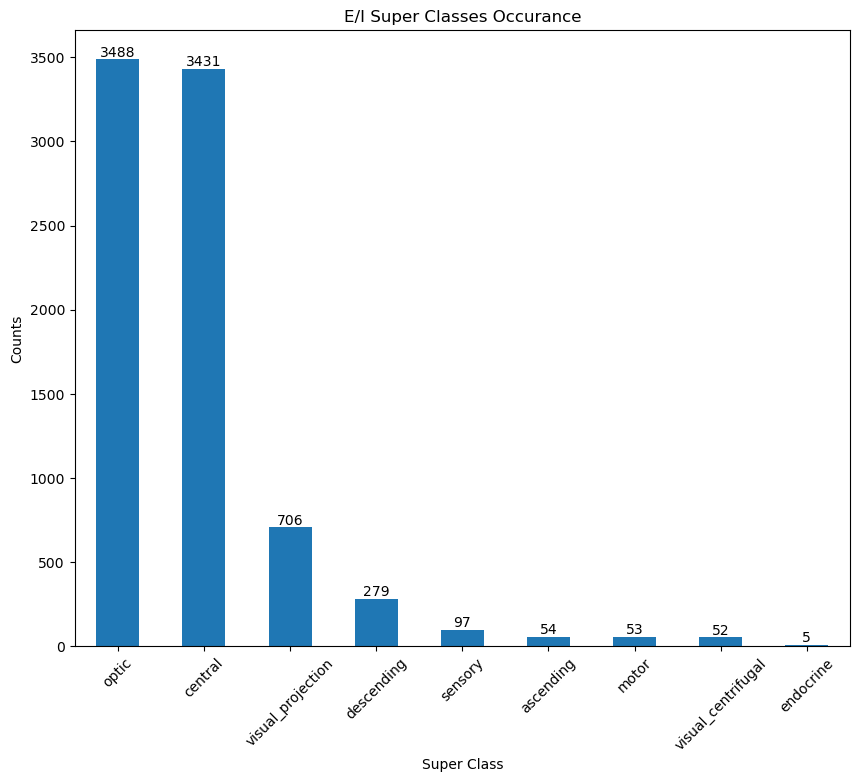

In [231]:
# bar chart of the occurance of each super class
fig, ax = plt.subplots(figsize=(10,8))
df_e_i_pairs_unique["super_class"].value_counts().plot(kind='bar')
plt.xticks(rotation=45)

# Add in labels for each bar
for i, v in enumerate(df_e_i_pairs_unique["super_class"].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
# Add a title to the plot
plt.title("E/I Super Classes Occurance")
plt.ylabel("Counts")
plt.xlabel("Super Class")

Text(0.5, 0, 'Super Class')

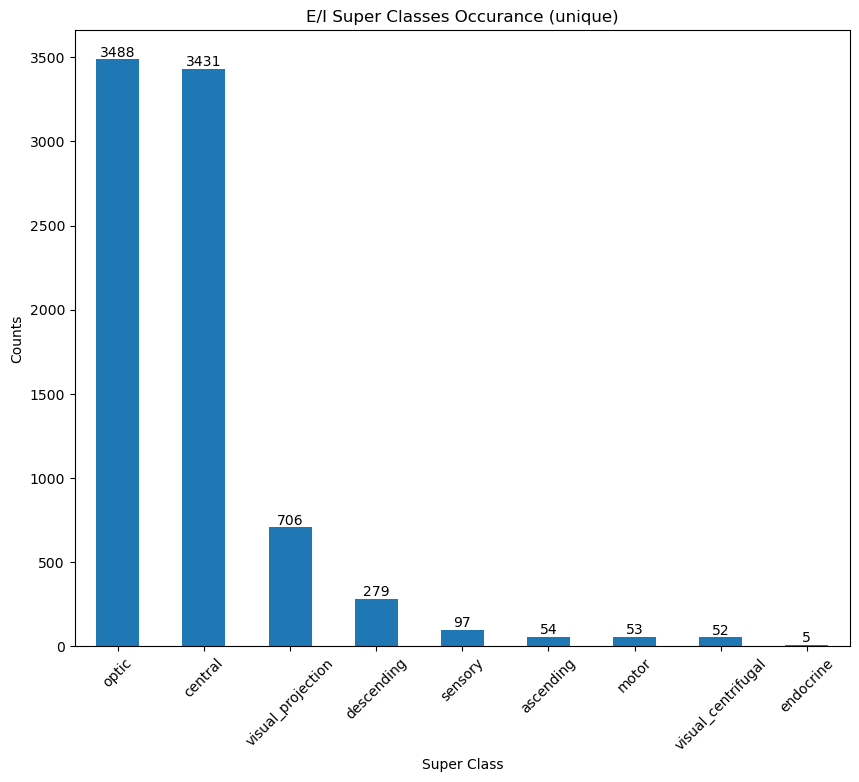

In [230]:
# bar chart of the occurance of each super class
fig, ax = plt.subplots(figsize=(10,8))
df_e_i_pairs_unique["super_class"].value_counts().plot(kind='bar')
plt.xticks(rotation=45)

# Add in labels for each bar
for i, v in enumerate(df_e_i_pairs_unique["super_class"].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
# Add a title to the plot
plt.title("E/I Super Classes Occurance (unique)")
plt.ylabel("Counts")
plt.xlabel("Super Class")

In [232]:
# Isolate the descending super class
df_e_i_pairs_desc = df_e_i_pairs_unique[df_e_i_pairs_unique['super_class']=='descending'].reset_index(drop=True)
df_e_i_pairs_desc

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,super_class
0,720575940604569824,720575940624471373,720575940610505006,GABA,ACH,descending
1,720575940604569824,720575940612685162,720575940631282194,GABA,ACH,descending
2,720575940638668659,720575940627491914,720575940627946261,GABA,ACH,descending
3,720575940637902938,720575940629393207,720575940621392086,ACH,GABA,descending
4,720575940637902938,720575940629393207,720575940623110123,ACH,GABA,descending
...,...,...,...,...,...,...
274,720575940611965593,720575940622204186,720575940621336852,GABA,ACH,descending
275,720575940616564534,720575940612054425,720575940609948514,GLUT,ACH,descending
276,720575940613657342,720575940617797259,720575940623431351,GABA,ACH,descending
277,720575940625395864,720575940632401233,720575940627691458,ACH,GABA,descending


In [210]:
df_pairs_info = triad_info(df_e_i_pairs_desc)
df_pairs_info

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940604569824,720575940624471373,AVLP_R,144,GABA,1
1,720575940604569824,720575940610505006,AVLP_R,72,GABA,1
2,720575940624471373,720575940604569824,AVLP_R,15,ACH,1
3,720575940624471373,720575940610505006,AVLP_R,23,ACH,1
4,720575940604569824,720575940612685162,AVLP_R,15,GABA,2
...,...,...,...,...,...,...
7895,720575940620691672,720575940628352850,SPS_L,16,ACH,1558
7896,720575940611720690,720575940620691672,SPS_L,64,GABA,1559
7897,720575940611720690,720575940620153765,SPS_L,19,GABA,1559
7898,720575940620691672,720575940611720690,SPS_L,21,ACH,1559


In [219]:
df_pairs_info = df_pairs_info.dropna()

# Group by triad and sum the syn_count values
triad_max_finder = df_pairs_info.groupby("triad")["syn_count"].sum().reset_index()
# sorts the values by syn_count in descending order
triad_max_finder = triad_max_finder.sort_values(by="syn_count", ascending=False).reset_index(drop=True)
triad_max_finder.head(10)

,triad,syn_count
0,1348,1004
1,1352,898
2,359,897
3,1351,881
4,300,849
5,287,843
6,521,840
7,1098,835
8,640,827
9,468,798


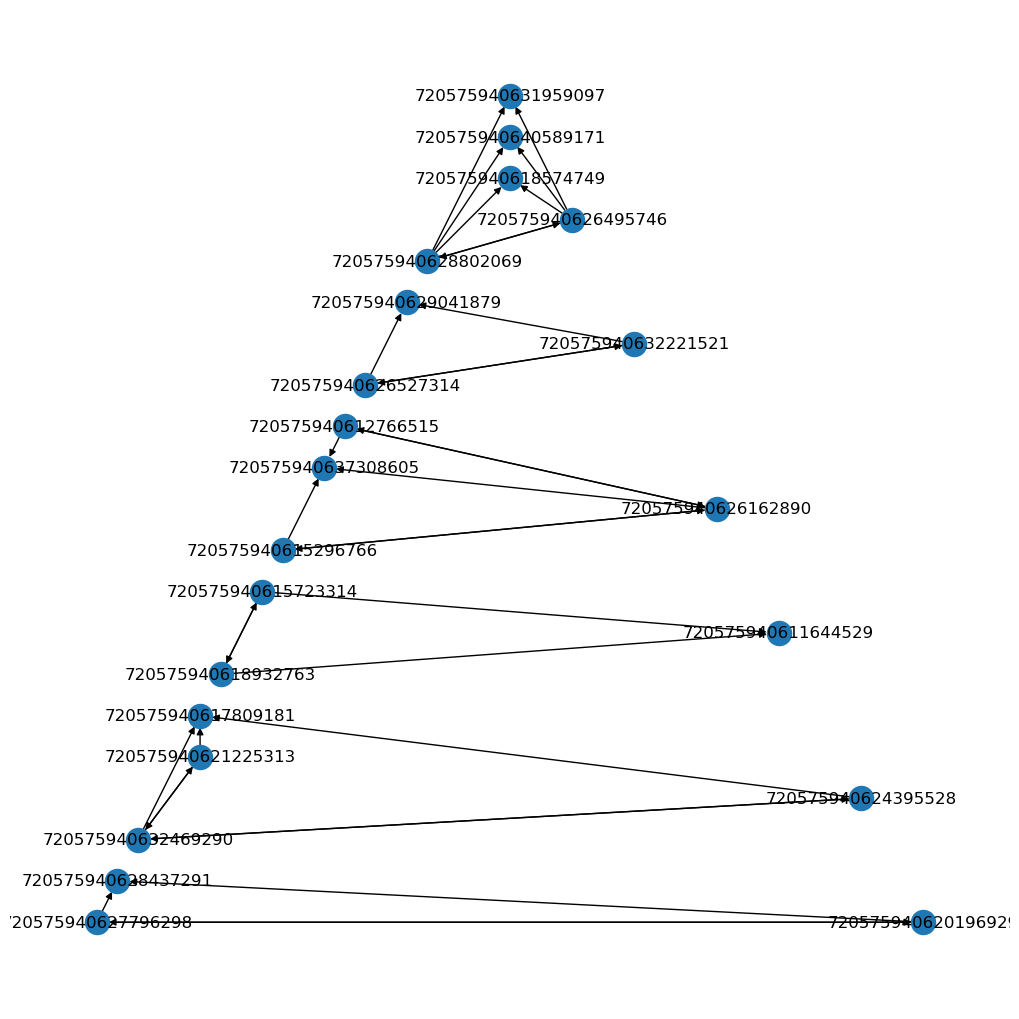

In [225]:
# Isolate top ten traids and plot their df_pairs_info
top_ten = triad_max_finder.head(10)

# Isolate the top ten triads
df_top_ten = df_pairs_info[df_pairs_info["triad"].isin(top_ten["triad"])].reset_index(drop=True)

# Make a network graph of the descending super class
G = nx.DiGraph()
plt.figure(figsize=(10, 10))
# Add the edges to the graph from dataframe
G.add_edges_from(df_top_ten[["pre_root_id", "post_root_id"]].values)
# Plot the graph
nx.draw_planar(G, with_labels=True)

In [234]:
df_top_ten

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940627796298,720575940620196929,AVLP_L,211,GABA,287
1,720575940627796298,720575940620196929,PVLP_L,32,GABA,287
2,720575940627796298,720575940628437291,PLP_L,56,GABA,287
3,720575940627796298,720575940628437291,PVLP_L,197,GABA,287
4,720575940627796298,720575940628437291,AVLP_L,93,GABA,287
5,720575940620196929,720575940627796298,AVLP_L,165,ACH,287
6,720575940620196929,720575940627796298,PVLP_L,70,ACH,287
7,720575940620196929,720575940628437291,AVLP_L,19,ACH,287
8,720575940624395528,720575940632469290,ICL_R,107,ACH,300
9,720575940624395528,720575940632469290,SPS_R,18,ACH,300
